

Il progetto **SAFE PATH** nasce con l’obiettivo di **predire il rischio di criminalità** lungo le strade urbane e guidare gli utenti , in particolare donne e bambini, attraverso **percorsi pedonali più sicuri**, grazie all’uso di tecniche avanzate di **intelligenza artificiale su grafi**.

In particolare, il sistema si propone di:
- Analizzare i dati storici dei crimini nella città di **Chicago**.
- Costruire un **grafo stradale pedonale** realistico basato su OpenStreetMap.
- Stimare il **rischio associato a ciascun segmento stradale** con un modello predittivo.
- Calcolare il **percorso ottimale in base alla sicurezza**, non solo alla distanza.

Il progetto unisce **machine learning**, **analisi spaziale** e **network science** per migliorare la vivibilità e la sicurezza urbana.


Le **Graph Neural Networks** (GNN) sono un tipo di rete neurale progettata per operare su **strutture a grafo**, dove i dati non sono indipendenti ma collegati da relazioni (nodi e archi).

Nel mio contesto:
- **I nodi** rappresentano i punti del grafo stradale (intersezioni).
- **Gli archi** rappresentano i segmenti stradali (strade percorribili).
- Ogni arco ha associate feature come: **ora media dei crimini, rischio di zona, lunghezza, e rischio stimato**.

Le GNN sono in grado di:
- Tenere conto del **contesto locale e delle connessioni** tra strade vicine.
- **Predire il rischio** su ogni arco anche in zone meno documentate.
- Generalizzare sfruttando la **struttura connettiva** del grafo urbano.

Le GNN rappresentano lo stato dell’arte nell’analisi su grafi e trovano applicazione in campi come:
- Mobilità urbana
- Sicurezza informatica
- Scienze biologiche
- Recommender systems


Un’applicazione concreta di **AI per il bene pubblico**, estendibile a qualsiasi città dotata di dati geospaziali e open data sui reati.


## 1. **Pulizia e Preparazione dei Dati per il progetto SAFE PATH**

Questo blocco di codice esegue la pulizia e la preparazione del dataset dei crimini di Chicago per l’analisi e la modellazione del rischio.

**Step principali:**

- **Import delle librerie**  
  Importa pandas, numpy e strumenti di clustering e normalizzazione da scikit-learn.

- **Caricamento del dataset**  
  Carica il file CSV dei crimini in un DataFrame pandas.

- **Selezione delle colonne utili**  
  Tiene solo le colonne rilevanti: data, tipo di crimine, luogo, arresto, domesticità, coordinate, area e blocco.

- **Rimozione dei dati mancanti**  
  Elimina le righe senza coordinate o tipo di crimine.

- **Parsing della data e ora**  
  Converte la colonna 'Date' in formato datetime, estrae anno e ora.

- **Filtro temporale**  
  Tiene solo i crimini dal 2018 in poi.

- **Filtro geografico**  
  Tiene solo i crimini avvenuti entro i limiti geografici di Chicago (per evitare outlier).

- **Calcolo del peso orario**  
  Applica una funzione che assegna un peso di rischio maggiore ai crimini avvenuti di notte.

- **Pulizia del campo Block**  
  Anonimizza il campo 'Block' sostituendo i numeri civici con la stringa 'BLOCK'.

- **Assegnazione dei pesi ai tipi di crimine**  
  Ogni tipo di crimine riceve un peso di gravità (es. HOMICIDE=1.0, THEFT=0.3, ecc.).

- **Calcolo del rischio pesato**  
  Calcola il rischio effettivo di ogni evento come prodotto tra peso orario e peso del crimine.

- **Normalizzazione dei booleani**  
  Converte le colonne 'Arrest' e 'Domestic' in valori 0/1.

- **Clustering geografico**  
  Applica KMeans per suddividere la città in 40 zone (GeoZone) sulla base delle coordinate.

- **Calcolo del rischio medio per zona**  
  Calcola il rischio medio normalizzato e il conteggio dei crimini per ogni zona.

- **Salvataggio dei dati puliti**  
  Salva il DataFrame pulito e i centroidi dei cluster per usi successivi.

In [ ]:
# SAFE PATH - Fase 1: Pulizia e preparazione dati (v3 con clustering geografico)
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# --------------------------
# 0. Caricamento dataset
# --------------------------
file_path = "../data/Crimes_-_2001_to_Present_20250621.csv"
df = pd.read_csv(file_path)

# --------------------------
# 1. Selezione colonne utili
# --------------------------
columns_to_keep = [
    'Date', 'Primary Type', 'Location Description', 'Arrest', 'Domestic',
    'Latitude', 'Longitude', 'Community Area', 'Block'
]
df = df[columns_to_keep].dropna(subset=['Latitude', 'Longitude', 'Primary Type'])

# --------------------------
# 2. Parsing data/ora ➜ estrai Year e Hour
# --------------------------
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df = df.dropna(subset=['Date'])
df['Year'] = df['Date'].dt.year
df['Hour'] = df['Date'].dt.hour

# --------------------------
# 3. Filtro temporale (dal 2018 in poi)
# --------------------------
df = df[df['Year'] >= 2018]

# --------------------------
# 4. Filtro geografico (evita outlier)
# --------------------------
df = df[ (df['Latitude'].between(41.64, 42.05)) & (df['Longitude'].between(-87.95, -87.5))]

# --------------------------
# 5. Calcolo peso orario (TimeWeight)
# --------------------------
def time_weight(hour: int) -> float:
    if 0 <= hour < 4:
        return 1.5
    elif 4 <= hour < 6:
        return 0.9
    elif 6 <= hour < 18:
        return 0.45
    else:
        return 1.0

df['TimeWeight'] = df['Hour'].apply(time_weight)

# --------------------------
# 6. Pulizia campo Block
# --------------------------
df['Block'] = df['Block'].str.replace(r'\d{3}X', 'BLOCK', regex=True)

# --------------------------
# 7. Pesi di gravità per tipo di crimine
# --------------------------
default_weight = 0.2
crime_weights = {cat: default_weight for cat in df['Primary Type'].unique()}
crime_weights.update({
    'HOMICIDE': 1.0,
    'CRIMINAL SEXUAL ASSAULT': 0.95,
    'KIDNAPPING': 0.82,
    'ROBBERY': 0.80,
    'ASSAULT': 0.77,
    'BATTERY': 0.63,
    'ARSON': 0.52,
    'BURGLARY': 0.53,
    'MOTOR VEHICLE THEFT': 0.45,
    'CRIMINAL DAMAGE': 0.34,
    'THEFT': 0.30,
    'NARCOTICS': 0.25,
})

df['CrimeWeight'] = df['Primary Type'].map(crime_weights)
df['WeightedCrime'] = df['TimeWeight'] * df['CrimeWeight']  #calcolato per ogni signolo evento

# --------------------------
# 8. Normalizzazione booleani
# --------------------------
df['Arrest'] = df['Arrest'].astype(int)
df['Domestic'] = df['Domestic'].astype(int)

# --------------------------
# 9. Categoria testuale e coordinate
# --------------------------
df['Crime Category'] = df['Primary Type']
df['geometry'] = list(zip(df.Longitude, df.Latitude))

# --------------------------
# 10. Clustering geografico per zone
# --------------------------
coords = df[['Latitude', 'Longitude']]
n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
df['GeoZone'] = kmeans.labels_

# --------------------------
# 11. ZoneRisk + conteggio eventi per zona
# --------------------------
zone_risk = df.groupby('GeoZone')['WeightedCrime'].mean().reset_index()
scaler = MinMaxScaler()
zone_risk['NormalizedZoneRisk'] = scaler.fit_transform(zone_risk[['WeightedCrime']])
df = df.merge(zone_risk[['GeoZone', 'NormalizedZoneRisk']], on='GeoZone', how='left')

zone_counts = df.groupby('GeoZone').size().reset_index(name='CrimeCount')
df = df.merge(zone_counts, on='GeoZone', how='left')

df['CrimeCountLog'] = np.log1p(df['CrimeCount'])  # log(1 + x) -> Logarithmic Transformation log1p per ev itare problemi se x vale 0 e mantiene le roporzioni per valori piccoli e permette sia di stabilizzare la varianza che rendere i dati piu gaussiani


# --------------------------
# 12. Salvataggio dataset pulito
# --------------------------
os.makedirs("../data", exist_ok=True)
df.reset_index(drop=True).to_csv("../data/cleaned_clustered_crime_data.csv", index=False)

# --------------------------
# 13. Salvataggio centroidi cluster per mappa
# --------------------------
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=["Latitude", "Longitude"])
centroids.to_json("../data/cluster_centroids.json", orient="records")

print("✅ Pulizia, clustering e salvataggi completati.")


✅ Pulizia, clustering e salvataggi completati.


### ATTRIBUTI CHE ABBIAMO ORA

| Attributo              | Descrizione                                                                                   |
|------------------------|----------------------------------------------------------------------------------------------|
| Date                   | Data e ora del crimine                                                                       |
| Primary Type           | Categoria principale del reato (es. THEFT, ASSAULT)                                          |
| Location Description   | Dove è avvenuto (es. STREET, APARTMENT)                                                      |
| Arrest                 | 1 = arresto effettuato, 0 = no                                                               |
| Domestic               | 1 = reato domestico                                                                          |
| Latitude, Longitude    | Coordinate geografiche del reato                                                             |
| Community Area         | Area urbana di Chicago (intorno a 77 aree totali)                                            |
| Block                  | Strada del crimine, anonimizzata                                                             |
| Year, Hour             | Anno e ora del giorno                                                                        |
| TimeWeight             | Peso orario del rischio (es. notte = più alto)                                               |
| CrimeWeight            | Peso di gravità del crimine                                                                  |
| WeightedCrime          | Rischio effettivo TOTALE: rischio pesato rispetto al crimine e alla fascia temporale         |
| Crime Category         | Alias per Primary Type                                                                       |
| geometry               | Tupla (lon, lat) utile per geoposizionamento                                                 |
| GeoZone                | ID del cluster geografico                                                                    |
| NormalizedZoneRisk     | Rischio medio normalizzato per zona (0–1)                                                    |
| CrimeCount             | Numero totale di crimini in quella zona                                                      |

### 2. **Preparazione delle feature spaziali e rischio sugli archi del grafo**

Questo blocco di codice esegue i seguenti passaggi fondamentali:

1. **Caricamento dei dati dei crimini**  
   - Si carica il file CSV dei crimini già pulito e clusterizzato.
   - Si estraggono le coordinate (latitudine, longitudine) e il rischio pesato (`WeightedCrime`) per ogni evento.

2. **Costruzione di un KDTree**  
   - Si crea una struttura KDTree sulle coordinate dei crimini per poter trovare rapidamente i crimini più vicini a un punto qualsiasi della città.

3. **Funzioni di utilità**  
   - `get_crimes_near(lat, lon, k=5)`: restituisce i k crimini più vicini a una posizione data.
   - `get_local_features(lat, lon)`: calcola statistiche locali (ora media, zona più frequente, rischio medio normalizzato, numero di crimini) attorno a una posizione.

4. **Costruzione del grafo stradale**  
   - Si scarica la rete stradale pedonale di Chicago tramite OSMnx.
   - Il grafo viene proiettato in coordinate metriche (UTM) per calcolare distanze reali.

5. **Calcolo della lunghezza degli archi**  
   - Per ogni arco (strada) del grafo, si calcola la lunghezza in metri usando la geometria reale se disponibile, altrimenti la distanza euclidea tra i nodi.

6. **Estrazione delle feature per ogni arco**  
   - Per ogni arco si calcolano:
     - Latitudine e longitudine del centro dell’arco.
     - Statistiche locali sui crimini vicini (ora media, zona, rischio zona, conteggio crimini).
     - La lunghezza dell’arco.
     - Il rischio vero (`risk_true`): media pesata del rischio dei crimini vicini, pesata in base alla distanza (più un crimine è vicino, più pesa).

7. **Risultato**  
   - Ogni arco del grafo ora contiene tutte le feature necessarie per l’analisi e la predizione del rischio


In [ ]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
import geopandas as gpd
from shapely.geometry import LineString
import pickle
from geopy.distance import great_circle


# === Prepara KDTree crimini per analisi spaziale ===
crime_df = pd.read_csv("../data/cleaned_clustered_crime_data.csv")
crime_coords = crime_df[['Latitude', 'Longitude']].to_numpy()
crime_weights = crime_df['WeightedCrime'].to_numpy()
crime_tree = KDTree(np.radians(crime_coords))

def get_crimes_near(lat, lon, k=5):
    coord_rad = np.radians([[lat, lon]])
    dists, idxs = crime_tree.query(coord_rad, k=k)
    return crime_df.iloc[idxs[0]]

def get_local_features(lat, lon):
    crimes_near = get_crimes_near(lat, lon, k=5)
    if crimes_near.empty:
        return 0.0, 0, 0.0, 0
    hour_avg = crimes_near['Hour'].mean()
    zone_ids = crimes_near['GeoZone'].values
    zone = np.bincount(zone_ids).argmax()  # zona più frequente
    zone_info = crimes_near[crimes_near['GeoZone'] == zone].iloc[0]
    return hour_avg, zone, zone_info['NormalizedZoneRisk'], zone_info['CrimeCount']

# === Carica grafo e prepara GeoDataFrame ===
G = ox.graph_from_place("Chicago, Illinois, USA", network_type='walk')
G = ox.project_graph(G) #standard coordinate in UTM (Universal Transverse Mercator) per calcolare le distanze in metri

# Aggiunge manualmente la lunghezza ad ogni arco (in metri)
for u, v, k, data in G.edges(keys=True, data=True):
    if 'geometry' in data: #se c e una geometria, uso quella per calcolare la lunghezza
        length = data['geometry'].length  # in metri, se il grafo è proiettato (UTM)
    else: #altrimenti uso la distanza euclidea
        x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
        x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
        length= ox.distance.euclidean(x1, y1, x2, y2)  # in metri
        
    G[u][v][k]['length'] = length

edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges_gdf = edges_gdf.to_crs(epsg=4326)

# Calcola feature personalizzate

feature_matrix = []
for (u, v, k), row in edges_gdf.iterrows():
    geom = row['geometry']

    centroide = geom.centroid
    lat, lon = centroide.y, centroide.x
    hour, geozone, zonerisk, crimecount = get_local_features(lat, lon)

    G[u][v][k]['lat'] = lat
    G[u][v][k]['lon'] = lon
    G[u][v][k]['hour'] = hour
    G[u][v][k]['GeoZone'] = geozone
    G[u][v][k]['NormalizedZoneRisk'] = zonerisk
    G[u][v][k]['CrimeCount'] = crimecount
    G[u][v][k]['length'] = G[u][v][k].get('length')

    crimes_near = get_crimes_near(lat, lon, k=5)

    if not crimes_near.empty:
        # Calcola distanza geodetica in metri tra centro arco e crimini vicini
        dists = crimes_near.apply(
            lambda row: great_circle((lat, lon), (row['Latitude'], row['Longitude'])).meters,
            axis=1
        )

        # Aggiungi un piccolo epsilon per evitare divisione per zero
        weights = 1 / (dists + 1e-3)

        # Calcolo della media pesata del rischio, un crimine avvenuto a 30 metri è piu importante di uno avvenuto a 400 per esempio
        weighted_avg = np.average(crimes_near['WeightedCrime'], weights=weights)

        G[u][v][k]['risk_true'] = float(weighted_avg)
    else:
        G[u][v][k]['risk_true'] = 0.0

### Salvataggio del grafo e delle feature spaziali

Questo blocco di codice si occupa di salvare i dati elaborati per futuri riutilizzi e per eventuali analisi o visualizzazioni GIS:

1. **Crea la cartella di destinazione**  
   - Se la cartella `../data` non esiste, viene creata automaticamente.

2. **Salva il grafo completo**  
   - Il grafo `G`, arricchito con tutte le feature di rischio e statistiche locali sugli archi, viene salvato in formato pickle (`graph_with_features.pkl`).  
   - Questo permette di ricaricare rapidamente il grafo senza dover ripetere tutta la fase di calcolo delle feature.

3. **Salva il GeoDataFrame degli archi**  
   - Il GeoDataFrame `edges_gdf`, che contiene tutte le informazioni sugli archi (inclusa la geometria e le feature di rischio), viene salvato in formato GeoJSON (`edges_with_features.geojson`).  
   - Questo formato è compatibile con software GIS come QGIS e può essere usato per visualizzazioni o analisi spaziali avanzate.

4. **Messaggio di conferma**  
   - Alla fine viene stampato un messaggio per confermare che il salvataggio è avvenuto con successo.


In [ ]:
#Salvo il grafo per futuri riutilizzi
# Crea cartella se non esiste
import os 
 
# Salva grafo completo
with open("../data/graph_with_features.pkl", "wb") as f:
    pickle.dump(G, f)

# Salva come GeoDataFrame (per GIS o debug)
edges_gdf.to_file("../data/edges_with_features.geojson", driver="GeoJSON")

print("Grafo e GeoDataFrame salvati.")


Grafo e GeoDataFrame salvati.


### 3. **Verifica della completezza degli attributi sugli archi del grafo**

Questo blocco di codice serve a **controllare che ogni arco del grafo** abbia tutti gli attributi necessari per le fasi successive di analisi e modellazione.  
Gli attributi richiesti sono:  
- `length`  
- `lat`  
- `lon`  
- `hour`  
- `GeoZone`  
- `NormalizedZoneRisk`  
- `CrimeCount`  
- `risk_true`  

**Cosa fa il codice:**
1. **Definisce la lista di attributi obbligatori** per ogni arco.
2. **Scorre tutti gli archi** del grafo `G` e verifica se manca qualcuno di questi attributi.
3. **Stampa un messaggio di warning** per ogni arco che ha attributi mancanti, indicando quali sono.
4. Alla fine, **stampa il numero totale di archi** nel grafo e nel GeoDataFrame, utile per confrontare che non ci siano discrepanze tra le due strutture dati.

**Motivazione delle scelte:**
- Questo controllo è fondamentale perché, nelle fasi successive (ad esempio la conversione per PyTorch Geometric o il salvataggio per GIS), **tutti gli archi devono avere lo stesso set di feature** e dello stesso tipo.  
- Se anche solo un arco manca di un attributo, si rischiano errori difficili da debuggare o risultati incoerenti nei modelli di machine learning.
- Il confronto tra il numero di archi nel grafo e nel GeoDataFrame permette di individuare eventuali problemi di sincronizzazione o perdita di dati tra le due rappresentazioni.


In [ ]:
import pickle

required_attrs = {
    "length",
    "lat",
    "lon",
    "hour",
    "GeoZone",
    "NormalizedZoneRisk",
    "CrimeCount",
    "risk_true"
}

for u, v, k, data in G.edges(keys=True, data=True):
    missing = [attr for attr in required_attrs if attr not in data]
    if missing:
        print(f"Edge ({u}, {v}, {k}) missing attributes: {missing}")


print(f"Tot edges in G: {len(G.edges(keys=True))}")
print(f"Tot edges in edges_gdf: {len(edges_gdf)}")



Tot edges in G: 975168
Tot edges in edges_gdf: 975168


### 4. **Pulizia degli attributi dei nodi prima della conversione a PyTorch Geometric**

Questo blocco di codice serve a **rimuovere tutti gli attributi dai nodi del grafo** prima di convertirlo in un oggetto PyTorch Geometric


- In questo progetto **le predizioni vengono fatte sugli archi** (edge-level), non sui nodi.
- PyTorch Geometric, durante la conversione con `from_networkx()`, può generare errori o conflitti se i nodi hanno attributi eterogenei o inutili, soprattutto se non sono coerenti tra loro o non servono al modello.
- Pulendo tutti gli attributi dei nodi si evita che informazioni non necessarie o formati incompatibili causino problemi nella pipeline di machine learning.
- In questo modo si garantisce che **solo le feature degli archi** (che sono quelle rilevanti per la predizione del rischio) vengano mantenute e utilizzate dal modello.

Era dunque necessario attuare una una misura di sicurezza per evitare errori di conversione e garantire che il grafo sia pronto per l’uso in PyTorch Geometric, mantenendo solo le informazioni realmente utili per il task di predizione.

In [ ]:
# 💡 Esegui prima della conversione con from_networkx() 
#rimuovo gli attributi dai nodi (perché io uso gli archi per fare predizione)  per evitare conflitti nel blocco successivo, da rivedere se uniformare gli attributi o eliminarli e basta cosi
for _, data in G.nodes(data=True):
    data.clear()



### 5. **Controllo dell’omogeneità dei tipi degli attributi sugli archi**

Questo blocco di codice serve a **verificare che ogni attributo degli archi del grafo abbia sempre lo stesso tipo** (ad esempio, tutti float o tutti int) per garantire la compatibilità e la robustezza della pipeline, evitando errori dovuti a tipi misti nei dati.

- PyTorch Geometric richiede che ogni feature abbia **lo stesso tipo su tutti gli archi** (ad esempio, tutti float32 o tutti int).
- Se anche solo un arco ha un tipo diverso (ad esempio `np.float64` invece di `float`), la conversione con `from_networkx()` può fallire o generare errori difficili da interpretare.
- Questo controllo permette di **individuare subito eventuali inconsistenze** nei tipi degli attributi, così da poterli uniformare prima della conversione.

 

In [ ]:
for attr in ["length", "lat", "lon", "hour", "GeoZone", "NormalizedZoneRisk", "CrimeCount", "risk_true"]:
    types = set(type(G[u][v][k].get(attr)) for u, v, k in G.edges(keys=True))
    print(f"{attr} → tipi trovati: {types}")


length → tipi trovati: {<class 'float'>, <class 'numpy.float64'>}
lat → tipi trovati: {<class 'float'>}
lon → tipi trovati: {<class 'float'>}
hour → tipi trovati: {<class 'numpy.float64'>}
GeoZone → tipi trovati: {<class 'numpy.int64'>}
NormalizedZoneRisk → tipi trovati: {<class 'numpy.float64'>}
CrimeCount → tipi trovati: {<class 'numpy.int64'>}
risk_true → tipi trovati: {<class 'float'>}


Torch Geometric è molto rigido: vuole tutti gli attributi dello stesso tipo per ogni feature. In particolare, non tollera differenze tra float e np.float64. Quindi funzione: uniformate_attributes

PyTorch (e torch_geometric) lavora su torch.float32 o float, e non tollera bene oggetti NumPy puri (np.float64, np.int64, ecc.) nei dizionari, soprattutto in from_networkx.

Usare float ti garantisce massima compatibilità e meno errori criptici.

La differenza pratica tra float e np.float64 è irrilevante in precisione nella maggior parte dei casi (sono entrambi a 64 bit).

Questo blocco di codice serve a **verificare che ogni arco del grafo abbia tutti gli attributi richiesti** (non solo che siano dello stesso tipo, ma che siano proprio presenti).



In [ ]:
import pickle

required_attrs = {
    "length",
    "lat",
    "lon",
    "hour",
    "GeoZone",
    "NormalizedZoneRisk",
    "CrimeCount",
    "risk_true"
}

missing_edges = []
for u, v, k, data in G.edges(keys=True, data=True):
    missing = required_attrs - data.keys()
    if missing:
        missing_edges.append(((u, v, k), missing))

print(f"🔎 Archi con attributi mancanti: {len(missing_edges)}")
if missing_edges:
    for i, (edge, missing) in enumerate(missing_edges[:5]):
        print(f"  Arco {edge} manca: {missing}")



🔎 Archi con attributi mancanti: 0


------------------------------------------------------------------------------
**Qual è la differenza tra il blocco 3 e il blocco 5?**

- **Questo blocco controlla la *presenza* degli attributi**: per ogni arco verifica che ci siano *tutti* gli attributi richiesti (non importa il tipo, ma che esistano).
- **Il blocco precedente controllava l'*omogeneità dei tipi***: per ogni attributo, verificava che il tipo fosse sempre lo stesso su tutti gli archi (ad esempio, tutti float o tutti int).
- **Perché servono entrambi?**  
  - Se manca anche solo un attributo su un arco, la conversione verso PyTorch Geometric (`from_networkx`) può fallire o produrre dati inconsistenti.
  - Se gli attributi ci sono ma hanno tipi diversi, si possono avere errori di tipo o comportamenti imprevisti nei modelli ML.


 
  - Blocco 5: garantisce che la struttura dei dati sia completa e omogenea (tutti gli archi hanno tutte le feature richieste).
  - Blocco 3: garantisce che i dati siano anche coerenti come tipo (tutti float, tutti int, ecc.).

Entrambi sono fondamentali per una pipeline robusta e senza errori nella fase di conversione

-------------------------------------------------------------------------------------------------------------------------------------------


## 6. **Uniformare i tipi degli attributi sugli archi**

Questo blocco definisce la funzione `uniformate_attributes(G)`, che **uniforma i tipi degli attributi sugli archi del grafo**.  
Serve a garantire che ogni attributo abbia sempre lo stesso tipo su tutti gli archi, requisito fondamentale per la compatibilità con PyTorch Geometric.

**Cosa fa la funzione:**
- Per ogni arco del grafo `G`, prende solo gli attributi richiesti:  
  `'length', 'lat', 'lon', 'hour', 'GeoZone', 'NormalizedZoneRisk', 'CrimeCount', 'risk_true'`
- Per ogni attributo:
  - Se è `GeoZone` o `CrimeCount`, lo converte in `int` (usando la funzione `safe_int`).
  - Tutti gli altri attributi vengono convertiti in `float` (usando la funzione `safe_float`).
  - Se la conversione fallisce, assegna `nan` (per i float) o `-1` (per gli int).
- Sostituisce il dizionario degli attributi dell’arco con quello appena creato, così **tutti gli archi avranno solo questi attributi e tutti dello stesso tipo**.

**Perché è importante:**
- PyTorch Geometric richiede che ogni feature abbia lo stesso tipo su tutti gli archi (ad esempio, tutti float32 o tutti int).
- Se anche solo un arco ha un tipo diverso (ad esempio `np.float64` invece di `float`), la conversione con `from_networkx()` può fallire o generare errori difficili da interpretare.
- Questa funzione elimina ogni ambiguità e garantisce la massima compatibilità e robustezza della pipeline.

`uniformate_attributes(G)` è il passaggio finale di pulizia che rende il grafo pronto per la conversione e l’uso in modelli di machine learning, evitando errori dovuti a tipi misti o dati sporchi.

In [ ]:
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import StandardScaler
import torch
import networkx as nx
import pickle


def uniformate_attributes(G):
    required_attrs = [
        'length', 'lat', 'lon', 'hour',
        'GeoZone', 'NormalizedZoneRisk', 'CrimeCount', 'risk_true'
    ]

    def safe_float(value):
        try:
            return float(value)
        except (TypeError, ValueError):
            return float('nan')

    def safe_int(value):
        try:
            return int(value)
        except (TypeError, ValueError):
            return -1

    for u, v, k in G.edges(keys=True):
        edge = G[u][v][k]
        cleaned_edge = {}
        for attr in required_attrs:
            value = edge.get(attr, None)
            if attr in ['GeoZone', 'CrimeCount']:
                cleaned_edge[attr] = safe_int(value)
            else:
                cleaned_edge[attr] = safe_float(value)
        G[u][v][k].clear()
        G[u][v][k].update(cleaned_edge)




### 7. **Aggiunta di `edge_idx`**

  - Viene chiamata la funzione `uniformate_attributes(G)` per assicurarsi che tutti gli archi abbiano gli stessi attributi e dello stesso tipo.
  - Viene aggiunto un nuovo attributo `edge_idx` a ogni arco, che rappresenta l’indice progressivo dell’arco. Questo è utile per mantenere la corrispondenza tra l’ordine degli archi nel grafo e le righe delle feature (`edge_attr`) in PyTorch Geometric.
  - Crea anche un dizionario `edge_to_index` che permette di risalire rapidamente dall’arco all’indice.



In [ ]:
# Uniforma gli attributi
uniformate_attributes(G)

# Aggiungi edge_idx per mantenere la corrispondenza con PyG
edge_to_index = {}
for i, (u, v, k) in enumerate(G.edges(keys=True)):
    G[u][v][k]['edge_idx'] = i
    edge_to_index[(u, v, k)] = i


## 8. **Conversione a PyG e Salvataggio del grafo**

  - Definisce quali attributi degli archi usare come feature (`edge_attrs`).
  - Carica il grafo già arricchito con `edge_idx`.
  - Converte il grafo in un oggetto PyTorch Geometric (`data_pyg`) usando solo gli attributi specificati.
  - Salva il dataset PyG su disco (`data_pyg.pt`) per un caricamento veloce nei modelli.
  - Salva anche il grafo con gli indici degli archi (`grafo_with_idx.pkl`), utile per future associazioni tra archi e predizioni.

In [ ]:
import pickle


# Attributi da includere come edge_attr (escludi edge_idx se non ti serve per il modello)
edge_attrs = ['length', 'lat', 'lon', 'hour', 'GeoZone', 'NormalizedZoneRisk', 'CrimeCount', 'risk_true']


# Carica grafo completo
with open("../data/grafo_with_idx.pkl", "rb") as f:
    G = pickle.load(f)

# Conversione a PyG
data_pyg = from_networkx(G, group_edge_attrs=edge_attrs)

# Salva dataset
torch.save(data_pyg, "../data/data_pyg.pt")

# Salva grafo con edge_idx incluso
with open("../data/grafo_with_idx.pkl", "wb") as f:
    pickle.dump(G, f)

## 9. **TECNICA DI HOLDOUT + EARLY STOPPING**

Questo blocco di codice applica la **tecnica di holdout** per la validazione e prepara i dati per il training di una rete neurale su grafi (GNN).

### Cos’è l’holdout?
L’**holdout** è una tecnica di validazione in cui il dataset viene suddiviso in due (o più) parti:
- **Training set** (qui 80%): usato per addestrare il modello.
- **Validation set** (qui 20%): usato per valutare le prestazioni del modello su dati mai visti durante l’addestramento.

Questo permette di stimare la capacità del modello di generalizzare su dati nuovi e di evitare l’overfitting.

### Cosa fa il codice?
1. **Carica i dati**:  
   `data_pyg.edge_attr` contiene tutte le feature degli archi, inclusa la variabile target (`risk_true`).

2. **Separa le feature dal target**:  
   - `data_pyg.y` prende la colonna target (rischio vero).
   - `data_pyg.edge_attr` mantiene solo le prime 7 colonne (le vere feature di input).

3. **Standardizza le feature**:  
   - Usa `StandardScaler` per portare tutte le feature su una scala simile (media 0, deviazione standard 1).  
   - Questo è importante per il deep learning perché aiuta la rete a convergere più velocemente e stabilmente.

4. **Crea le maschere di train/validation**:  
   - Divide gli archi in modo casuale (ma riproducibile) in 80% train e 20% validation.
   - Crea due maschere booleane (`train_mask`, `val_mask`) che indicano quali archi usare per il training e quali per la validazione.

5. **Salva le maschere nel data object**:  
   - Queste maschere saranno usate durante il training per calcolare la loss solo sugli archi di train o validation.

### Perché usare l’holdout nel deep learning (e nelle GNN)?
- **Semplicità e velocità**: L’holdout è facile da implementare e veloce da eseguire, soprattutto su dataset grandi.
- **Evita overfitting**: Permette di monitorare la performance su dati non visti e fermare l’addestramento quando la validazione smette di migliorare (**early stopping**).
- **Adatto alle GNN**: Nelle reti su grafi, spesso si lavora con un solo grande grafo (non tanti piccoli), quindi la divisione in train/validation si fa a livello di archi (o nodi), non di grafi interi.

### Early stopping
- Durante il training, si monitora la loss di validazione.
- Se la loss di validazione non migliora per un certo numero di epoche, si interrompe l’addestramento.
- Questo previene l’overfitting e salva il modello “migliore” (quello con la loss di validazione più bassa).


**Perché Holdout con early stopping ?**
Si è scelto di applicare l’holdout con early stopping perché è una strategia robusta e pratica per valutare e addestrare modelli di deep learning su grafi, garantendo che il modello impari a generalizzare e non

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

data_pyg = torch.load("../data/data_pyg.pt", weights_only=False)

# Ora data_pyg.edge_attr ha shape [num_edges, 8] — tutte le features comprese 'risk_true'

# Separa il target (ultima colonna) e le feature (prime 7 colonne)
data_pyg.y = data_pyg.edge_attr[:, 7]
data_pyg.edge_attr = data_pyg.edge_attr[:, :7]

# (Opzionale) Standardizzazione delle feature
scaler = StandardScaler()
data_pyg.edge_attr = torch.tensor(scaler.fit_transform(data_pyg.edge_attr), dtype=torch.float)

# Numero di archi
num_edges = data_pyg.edge_attr.shape[0]
indices = np.arange(num_edges)

# 80% train, 20% validation
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

data_pyg.train_mask = train_mask
data_pyg.val_mask = val_mask


In [ ]:
print(data_pyg.train_mask )
print(data_pyg.val_mask)
print(data_pyg.y)

## 10. **Tecnica dell'Early Stopping con Training Loop**

La tecnica dell'**early stopping** è uno strumento fondamentale per prevenire l'**overfitting** nei modelli di deep learning. Viene implementata all'interno del **training loop**, ovvero il ciclo di addestramento che viene ripetuto per un certo numero di epoche.

### Cos'è un training loop?

Il training loop è una sequenza di operazioni che vengono eseguite per ogni **epoca** (passaggio su tutto il dataset di training). Comprende due fasi principali:

### Fase di training (`model.train()`)

Questa fase viene eseguita sul **training set**, ovvero i dati usati per far apprendere il modello.

- `model.train()` attiva la **modalità di addestramento**: in questa modalità, componenti come i **dropout** e **batch normalization** funzionano in modo attivo e casuale, simulando situazioni diverse per migliorare la capacità del modello di generalizzare.
- Si calcolano le **predizioni** del modello.
- Si calcola la **loss** (funzione di costo) tra predizioni e valori reali.
- Si esegue il **backpropagation** (`loss.backward()`): il gradiente viene calcolato per ogni parametro del modello.
- Si aggiornano i parametri del modello con l'**ottimizzatore** (`optimizer.step()`).
- Si azzerano i gradienti accumulati con `optimizer.zero_grad()` per evitare che si sommino tra un batch e l'altro.

### Fase di validazione (`model.eval()`)

Questa fase valuta il modello sul **validation set**, cioè un sottoinsieme dei dati non visto durante il training.

- `model.eval()` attiva la **modalità di valutazione**: in questa modalità, dropout e batch normalization vengono disattivati o fissati, così da rendere la valutazione stabile e coerente.
- Si fanno **predizioni** sul validation set.
- La loss viene calcolata **senza aggiornare i pesi**. Per evitare calcoli inutili dei gradienti, si racchiude questa fase in un blocco `with torch.no_grad()`.

### Monitoraggio delle performance

Dopo ogni epoca:
- Si stampa la **training loss** e la **validation loss**.
- Se la validation loss migliora (cioè diminuisce), si salva una **copia dello stato attuale del modello** (checkpoint) e si azzera il contatore `wait`.
- Se invece la validation loss **non migliora**, il contatore `wait` viene incrementato.

---

### Early Stopping

L'early stopping entra in azione quando la validation loss **non migliora per un numero definito di epoche consecutive** (parametro `patience`).

- Se `wait >= patience`, l'addestramento si interrompe.
- In questo modo si evita che il modello continui ad apprendere pattern inutili o rumore presente nei dati di training, riducendo così l'**overfitting**.
- Alla fine, si può ripristinare il **modello migliore** salvato durante l'ultima epoca con la loss minima.

### Perché è importante?

- **Previene l'overfitting:** interrompe l'addestramento prima che il modello inizi a "memorizzare" i dati.
- **Riduce i tempi di addestramento:** si evita di sprecare tempo computazionale in epoche inutili.
- **Conserva il modello migliore:** permette di mantenere lo stato del modello che ha ottenuto le migliori prestazioni sul validation set.

- `model.train()` e `model.eval()` **non eseguono l’addestramento o la valutazione di per sé**, ma **cambiano il comportamento interno del modello** (es. attivazione/disattivazione di dropout e batch norm).
- `torch.no_grad()` è utile per **velocizzare la validazione** e risparmiare memoria, perché evita il tracciamento del grafo computazionale.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class RiskGNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.edge_encoder = nn.Linear(in_channels, 32) #32 indica quanti neuroni nella prima hidden layer
        self.conv1 = GCNConv(32, 64)
        self.conv2 = GCNConv(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_attr):
        edge_feat = F.relu(self.edge_encoder(edge_attr))   # Encode edge features
        x = self.conv1(edge_feat, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.out(x).squeeze()  # Ritorna un valore per ogni arco


device = torch.device('cpu') #uso cpu perché non ho gpu NVIDIA con cuda
model = RiskGNN(in_channels=data_pyg.edge_attr.shape[1]).to(device)
data_pyg = data_pyg.to(device) #eseguo in locale e non su esterni
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 10
wait = 0
best_model_state = None
best_epoch = 0

print("Training con early stopping...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    out = model(data_pyg.x, data_pyg.edge_index, data_pyg.edge_attr)
    loss = criterion(out[train_mask], data_pyg.y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out = model(data_pyg.x, data_pyg.edge_index, data_pyg.edge_attr)
        val_loss = criterion(val_out[val_mask], data_pyg.y[val_mask])

    print(f" Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch
        wait = 0

        
       
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping a epoch {epoch}. Best epoch: {best_epoch}")
            break





Training con early stopping...
 Epoch 001 | Train Loss: 0.0846 | Val Loss: 0.0258
 Epoch 002 | Train Loss: 0.0259 | Val Loss: 0.0348
 Epoch 003 | Train Loss: 0.0350 | Val Loss: 0.0214
 Epoch 004 | Train Loss: 0.0215 | Val Loss: 0.0171
 Epoch 005 | Train Loss: 0.0172 | Val Loss: 0.0189
 Epoch 006 | Train Loss: 0.0189 | Val Loss: 0.0204
 Epoch 007 | Train Loss: 0.0205 | Val Loss: 0.0205
 Epoch 008 | Train Loss: 0.0205 | Val Loss: 0.0193
 Epoch 009 | Train Loss: 0.0193 | Val Loss: 0.0176
 Epoch 010 | Train Loss: 0.0177 | Val Loss: 0.0163
 Epoch 011 | Train Loss: 0.0164 | Val Loss: 0.0158
 Epoch 012 | Train Loss: 0.0159 | Val Loss: 0.0163
 Epoch 013 | Train Loss: 0.0164 | Val Loss: 0.0170
 Epoch 014 | Train Loss: 0.0171 | Val Loss: 0.0172
 Epoch 015 | Train Loss: 0.0173 | Val Loss: 0.0168
 Epoch 016 | Train Loss: 0.0169 | Val Loss: 0.0161
 Epoch 017 | Train Loss: 0.0161 | Val Loss: 0.0156
 Epoch 018 | Train Loss: 0.0156 | Val Loss: 0.0154
 Epoch 019 | Train Loss: 0.0155 | Val Loss: 0.0156


## 11. **Visualizzazione dell'andamento di training e validation**

Questo codice serve a **visualizzare l’andamento della loss di training e validazione** durante il training di una rete neurale, per analizzare il comportamento dell’early stopping.

### Cosa fa il codice?

1. **Parsing del log**  
   - Il log contiene le righe stampate durante il training (`Epoch ... | Train Loss: ... | Val Loss: ...`).
   - Si estraggono i valori di train loss e validation loss per ogni epoca usando una regex.

2. **Stampa dei valori**  
   - Vengono stampate le liste dei valori di train loss e val loss per verifica.

3. **Individuazione della best epoch**  
   - Si trova l’epoca in cui la validation loss è minima (`best_epoch`), che corrisponde al punto di early stopping.

4. **Plot dell’andamento**  
   - Si crea un grafico con matplotlib:
     - Linea blu: andamento della train loss.
     - Linea arancione: andamento della validation loss.
     - Linea verticale rossa: epoca di early stopping (best_epoch).
   - Si aggiungono etichette, legenda e griglia per chiarezza.

### Perché è utile?

- **Diagnosi del training:**  
  Permette di vedere se il modello sta imparando (loss che scende) e se inizia a overfittare (validation loss che risale).
- **Early stopping:**  
  Visualizza chiaramente il punto in cui il training si sarebbe dovuto fermare per evitare overfitting.
- **Comunicazione:**  
  Un grafico come questo è molto utile per report, presentazioni o debugging.


Train Losses: [0.0846, 0.0259, 0.035, 0.0215, 0.0172, 0.0189, 0.0205, 0.0205, 0.0193, 0.0177, 0.0164, 0.0159, 0.0164, 0.0171, 0.0173, 0.0169, 0.0161, 0.0156, 0.0155, 0.0156, 0.0158, 0.016, 0.016, 0.0158, 0.0156, 0.0154, 0.0153, 0.0153, 0.0154, 0.0155, 0.0155, 0.0154, 0.0153, 0.0152, 0.0151, 0.0151, 0.0152, 0.0152, 0.0152, 0.0152, 0.0151, 0.0151, 0.015, 0.015, 0.0151, 0.0151, 0.0151, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148,

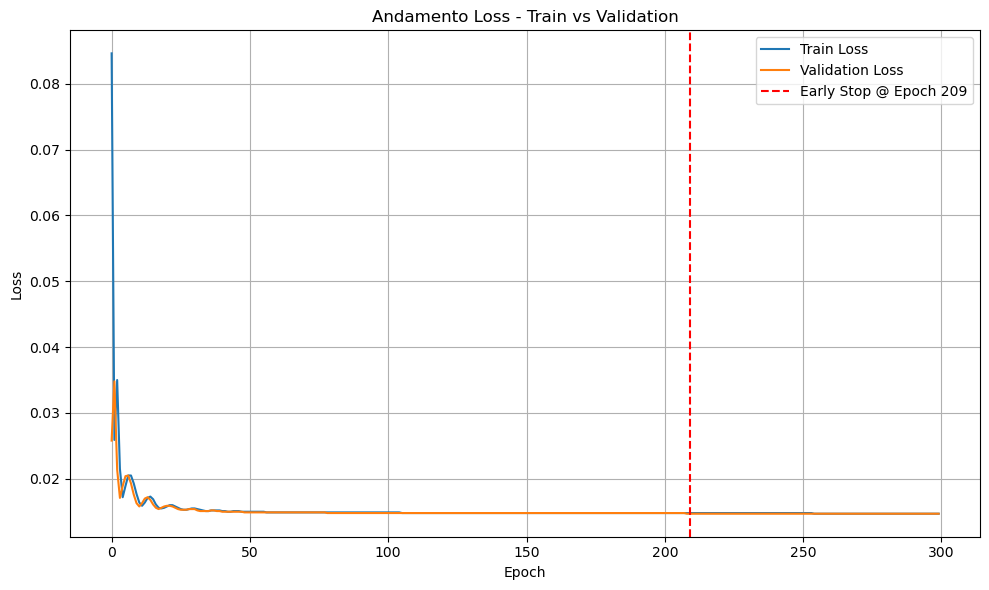

In [ ]:
import re
import matplotlib.pyplot as plt

#start log
log = """
 Training con early stopping...
 Epoch 001 | Train Loss: 0.0846 | Val Loss: 0.0258
 Epoch 002 | Train Loss: 0.0259 | Val Loss: 0.0348
 Epoch 003 | Train Loss: 0.0350 | Val Loss: 0.0214
 Epoch 004 | Train Loss: 0.0215 | Val Loss: 0.0171
 Epoch 005 | Train Loss: 0.0172 | Val Loss: 0.0189
 Epoch 006 | Train Loss: 0.0189 | Val Loss: 0.0204
 Epoch 007 | Train Loss: 0.0205 | Val Loss: 0.0205
 Epoch 008 | Train Loss: 0.0205 | Val Loss: 0.0193
 Epoch 009 | Train Loss: 0.0193 | Val Loss: 0.0176
 Epoch 010 | Train Loss: 0.0177 | Val Loss: 0.0163
 Epoch 011 | Train Loss: 0.0164 | Val Loss: 0.0158
 Epoch 012 | Train Loss: 0.0159 | Val Loss: 0.0163
 Epoch 013 | Train Loss: 0.0164 | Val Loss: 0.0170
 Epoch 014 | Train Loss: 0.0171 | Val Loss: 0.0172
 Epoch 015 | Train Loss: 0.0173 | Val Loss: 0.0168
 Epoch 016 | Train Loss: 0.0169 | Val Loss: 0.0161
 Epoch 017 | Train Loss: 0.0161 | Val Loss: 0.0156
 Epoch 018 | Train Loss: 0.0156 | Val Loss: 0.0154
 Epoch 019 | Train Loss: 0.0155 | Val Loss: 0.0156
 Epoch 020 | Train Loss: 0.0156 | Val Loss: 0.0158
 Epoch 021 | Train Loss: 0.0158 | Val Loss: 0.0159
 Epoch 022 | Train Loss: 0.0160 | Val Loss: 0.0159
 Epoch 023 | Train Loss: 0.0160 | Val Loss: 0.0158
 Epoch 024 | Train Loss: 0.0158 | Val Loss: 0.0156
 Epoch 025 | Train Loss: 0.0156 | Val Loss: 0.0154
 Epoch 026 | Train Loss: 0.0154 | Val Loss: 0.0153
 Epoch 027 | Train Loss: 0.0153 | Val Loss: 0.0153
 Epoch 028 | Train Loss: 0.0153 | Val Loss: 0.0153
 Epoch 029 | Train Loss: 0.0154 | Val Loss: 0.0154
 Epoch 030 | Train Loss: 0.0155 | Val Loss: 0.0154
 Epoch 031 | Train Loss: 0.0155 | Val Loss: 0.0154
 Epoch 032 | Train Loss: 0.0154 | Val Loss: 0.0152
 Epoch 033 | Train Loss: 0.0153 | Val Loss: 0.0151
 Epoch 034 | Train Loss: 0.0152 | Val Loss: 0.0151
 Epoch 035 | Train Loss: 0.0151 | Val Loss: 0.0151
 Epoch 036 | Train Loss: 0.0151 | Val Loss: 0.0151
 Epoch 037 | Train Loss: 0.0152 | Val Loss: 0.0152
 Epoch 038 | Train Loss: 0.0152 | Val Loss: 0.0152
 Epoch 039 | Train Loss: 0.0152 | Val Loss: 0.0151
 Epoch 040 | Train Loss: 0.0152 | Val Loss: 0.0151
 Epoch 041 | Train Loss: 0.0151 | Val Loss: 0.0150
 Epoch 042 | Train Loss: 0.0151 | Val Loss: 0.0150
 Epoch 043 | Train Loss: 0.0150 | Val Loss: 0.0150
 Epoch 044 | Train Loss: 0.0150 | Val Loss: 0.0150
 Epoch 045 | Train Loss: 0.0151 | Val Loss: 0.0150
 Epoch 046 | Train Loss: 0.0151 | Val Loss: 0.0150
 Epoch 047 | Train Loss: 0.0151 | Val Loss: 0.0150
 Epoch 048 | Train Loss: 0.0150 | Val Loss: 0.0150
 Epoch 049 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 050 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 051 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 052 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 053 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 054 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 055 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 056 | Train Loss: 0.0150 | Val Loss: 0.0149
 Epoch 057 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 058 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 059 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 060 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 061 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 062 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 063 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 064 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 065 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 066 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 067 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 068 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 069 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 070 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 071 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 072 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 073 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 074 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 075 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 076 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 077 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 078 | Train Loss: 0.0149 | Val Loss: 0.0149
 Epoch 079 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 080 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 081 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 082 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 083 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 084 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 085 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 086 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 087 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 088 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 089 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 090 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 091 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 092 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 093 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 094 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 095 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 096 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 097 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 098 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 099 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 100 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 101 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 102 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 103 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 104 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 105 | Train Loss: 0.0149 | Val Loss: 0.0148
 Epoch 106 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 107 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 108 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 109 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 110 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 111 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 112 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 113 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 114 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 115 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 116 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 117 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 118 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 119 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 120 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 121 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 122 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 123 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 124 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 125 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 126 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 127 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 128 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 129 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 130 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 131 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 132 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 133 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 134 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 135 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 136 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 137 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 138 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 139 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 140 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 141 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 142 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 143 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 144 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 145 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 146 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 147 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 148 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 149 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 150 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 151 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 152 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 153 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 154 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 155 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 156 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 157 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 158 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 159 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 160 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 161 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 162 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 163 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 164 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 165 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 166 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 167 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 168 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 169 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 170 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 171 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 172 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 173 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 174 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 175 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 176 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 177 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 178 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 179 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 180 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 181 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 182 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 183 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 184 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 185 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 186 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 187 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 188 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 189 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 190 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 191 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 192 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 193 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 194 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 195 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 196 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 197 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 198 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 199 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 200 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 201 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 202 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 203 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 204 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 205 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 206 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 207 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 208 | Train Loss: 0.0148 | Val Loss: 0.0148
 Epoch 209 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 210 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 211 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 212 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 213 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 214 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 215 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 216 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 217 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 218 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 219 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 220 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 221 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 222 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 223 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 224 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 225 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 226 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 227 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 228 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 229 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 230 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 231 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 232 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 233 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 234 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 235 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 236 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 237 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 238 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 239 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 240 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 241 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 242 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 243 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 244 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 245 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 246 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 247 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 248 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 249 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 250 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 251 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 252 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 253 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 254 | Train Loss: 0.0148 | Val Loss: 0.0147
 Epoch 255 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 256 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 257 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 258 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 259 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 260 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 261 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 262 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 263 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 264 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 265 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 266 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 267 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 268 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 269 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 270 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 271 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 272 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 273 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 274 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 275 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 276 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 277 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 278 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 279 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 280 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 281 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 282 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 283 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 284 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 285 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 286 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 287 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 288 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 289 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 290 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 291 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 292 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 293 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 294 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 295 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 296 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 297 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 298 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 299 | Train Loss: 0.0147 | Val Loss: 0.0147
 Epoch 300 | Train Loss: 0.0147 | Val Loss: 0.0147
"""

#end log

# Parsing
train_losses = []
val_losses = []

for line in log.splitlines():
    match = re.search(r"Train Loss: ([\d\.]+) \| Val Loss: ([\d\.]+)", line)
    if match:
        train_losses.append(float(match.group(1)))
        val_losses.append(float(match.group(2)))

# Verifica
print("Train Losses:", train_losses)
print("Val Losses:", val_losses)

# Plot 
best_epoch = val_losses.index(min(val_losses)) + 1  # +1 perché gli epoch partono da 1

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Early Stop @ Epoch {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Andamento Loss - Train vs Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




**Blocco: Caricamento modello e best epoch**

- Carica il checkpoint salvato (`training_phase1_checkpoint.pth`) che contiene:
  - I pesi migliori del modello (`model_state_dict`)
  - L’epoca migliore raggiunta (`best_epoch`)
  - Lo scaler usato per la standardizzazione (opzionale)
- Stampa l’epoca migliore trovata durante il training.
- Ricrea l’istanza del modello (`RiskGNN`) e carica i pesi migliori per poter fare predizioni o ulteriori addestramenti.


In [ ]:
 # Salva modello e metadati
torch.save({
    'model_state_dict': best_model_state,
    'best_epoch': best_epoch,
    'scaler': scaler  # opzionale se standardizzi le feature
}, "../data/training_phase1_checkpoint.pth")

print("Checkpoint salvato in ../data/training_phase1_checkpoint.pth")

Checkpoint salvato in ../data/training_phase1_checkpoint.pth


Carica il modello e la BEST_EPOCH

In [ ]:
# Carica modello e best_epoch
checkpoint = torch.load("../data/training_phase1_checkpoint.pth",weights_only=False) #modello salvato con la best epoch del odello iniziato ma nonn lamigliore
best_epoch = checkpoint['best_epoch']
print(f"Best epoch: {best_epoch}")
best_model_state = checkpoint['model_state_dict']


# Reinizializza modello e carica i pesi migliori
final_model = RiskGNN(in_channels=data_pyg.edge_attr.shape[1]).to(device)
final_model.load_state_dict(best_model_state)



Best epoch: 209


<All keys matched successfully>

## 12. **Riaddestramento Finale su Tutti i Dati**

### Cos'è il riaddestramento finale?

Dopo aver usato una **procedura di early stopping** per trovare il numero ottimale di epoche (`best_epoch`), si può eseguire un nuovo addestramento del modello utilizzando **tutti i dati disponibili**, incluse le porzioni che prima erano destinate alla validazione.

### Cosa fa esattamente questo passaggio?

1. **Estensione del training set**  
   - Tutti gli archi (o nodi, a seconda del task) vengono inclusi nel training set: si imposta `train_mask = True` per l'intero grafo.
   - In questo modo, il modello ha accesso a **tutte le informazioni** del dataset per imparare.

2. **Reinizializzazione del modello e dell'ottimizzatore**  
   - Si crea un nuovo modello (`final_model`) con la stessa architettura.
   - L'ottimizzatore viene ricreato da zero, azzerando i gradienti precedenti.

3. **Retrain per un numero controllato di epoche**  
   - Il modello viene riaddestrato per esattamente `best_epoch` epoche (ottenute dalla fase di early stopping).
   - Non viene più usata la validazione: si allena solo sul training set esteso.

4. **Logging e salvataggio**  
   - La loss viene stampata ogni 10 epoche e all'ultima epoca per tracciare l’andamento.
   - Al termine, si salvano:
     - I **pesi del modello** (`.pth`): utili per caricare solo i parametri.
     - Il **modello completo** (inclusa architettura e stato): utile per il riutilizzo diretto.

### Perché è importante?

- **Sfrutta tutti i dati disponibili**  
  Dopo aver trovato il numero ottimale di epoche, ha senso permettere al modello di apprendere anche dai dati che prima erano riservati alla validazione.

- **Migliora la generalizzazione**  
  Più dati vuol dire migliori stime dei pesi e una capacità maggiore di cogliere pattern utili.

- **Garantisce la riproducibilità**  
  Salvando sia i pesi che l'intero modello, si può:
  - Riusare il modello per predizioni future.
  - Condividere il modello con altri.
  - Ricaricarlo per ulteriori analisi o tuning.


In [ ]:
# Unifica tutti gli archi per riaddestramento finale
data_pyg.train_mask[:] = True

# Reinizializza modello
final_model = RiskGNN(in_channels=data_pyg.edge_attr.shape[1]).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.01)


# Retrain per best_epoch epoche
print(f" Retrain finale su tutto il dataset per {best_epoch} epoche...") #best epoch -> intorno a 176
for epoch in range(1, best_epoch + 1):
    final_model.train()
    optimizer.zero_grad()
    out = final_model(data_pyg.x, data_pyg.edge_index, data_pyg.edge_attr)
    loss = criterion(out[data_pyg.train_mask], data_pyg.y[data_pyg.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch == best_epoch:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

#SALVO IL MODELLO FINALE RIADDESTRATO
torch.save(final_model.state_dict(), "../data/final_model_weights.pth")

# Salva tutto il modello (non solo i pesi)
torch.save(final_model, "../data/final_model_alldata.pth")


 Retrain finale su tutto il dataset per 209 epoche...
Epoch 010 | Loss: 0.0195
Epoch 020 | Loss: 0.0161
Epoch 030 | Loss: 0.0155
Epoch 040 | Loss: 0.0152
Epoch 050 | Loss: 0.0151
Epoch 060 | Loss: 0.0150
Epoch 070 | Loss: 0.0149
Epoch 080 | Loss: 0.0149
Epoch 090 | Loss: 0.0149
Epoch 100 | Loss: 0.0149
Epoch 110 | Loss: 0.0149
Epoch 120 | Loss: 0.0149
Epoch 130 | Loss: 0.0148
Epoch 140 | Loss: 0.0148
Epoch 150 | Loss: 0.0148
Epoch 160 | Loss: 0.0148
Epoch 170 | Loss: 0.0148
Epoch 180 | Loss: 0.0148
Epoch 190 | Loss: 0.0148
Epoch 200 | Loss: 0.0148
Epoch 209 | Loss: 0.0148


final_model_weights.pth contiene solo i pesi (state_dict) del modello;

Quando vuoi riutilizzarli, devi ricreare l’istanza del modello con la stessa architettura (RiskGNN) e poi fare load_state_dict(...).

## 13. **Predizione Aggiornata**

### Assegnazione delle Predizioni agli Archi del Grafo

Questo blocco di codice esegue la **predizione del rischio** su ogni arco di un grafo stradale, utilizzando un modello PyTorch Geometric già addestrato, e **salva il grafo aggiornato** con i valori predetti.

### Ricaricamento del grafo

Viene caricato un grafo salvato precedentemente in formato pickle (`grafo_with_idx.pkl`). Questo grafo contiene, tra le informazioni associate agli archi, anche un campo `'edge_idx'`, che collega ogni arco a un indice nel tensore degli archi del modello PyG.

### Predizione con il modello finale

- Il modello (`final_model`) viene messo in modalità **valutazione** con `eval()`, disattivando dropout e batch normalization per garantire predizioni stabili.
- Si disattiva il calcolo dei gradienti con `torch.no_grad()`, per risparmiare memoria e velocizzare il processo.
- Si eseguono le predizioni su **tutti gli archi** del grafo (`data_pyg.edge_index` e `data_pyg.edge_attr`) e si ottiene un array NumPy contenente i valori predetti (`y_pred`), uno per ogni arco.

### Associazione delle predizioni agli archi

- Per ogni arco `(u, v, k)` del grafo:
  - Si recupera l’indice `edge_idx` (precalcolato e salvato in precedenza).
  - Se presente, si assegna la predizione corrispondente `y_pred[idx]` al campo `'risk_pred'` dell’arco.
  - Questo collega correttamente l’output del modello all’arco corrispondente nel grafo.

---

### Salvataggio del grafo aggiornato

Infine, il grafo aggiornato con i valori di rischio predetti (`risk_pred`) viene salvato in un nuovo file (`grafo_with_preds.pkl`), pronto per essere visualizzato o analizzato.

---

### Servirà poi per...

Questo passaggio è essenziale quando si vogliono:
- Visualizzare le **zone di rischio** su una mappa.
- Usare le predizioni del modello per **analisi successive** o per prendere decisioni (es. pianificare percorsi sicuri).
- Collegare le predizioni numeriche del modello ai **dati geografici reali** del grafo.



In [ ]:
import torch
# Ricarica grafo con edge_idx già salvati
with open("../data/grafo_with_idx.pkl", "rb") as f:
    G = pickle.load(f)
    
final_model.eval()
with torch.no_grad():
    y_pred = final_model(data_pyg.x, data_pyg.edge_index, data_pyg.edge_attr).cpu().numpy()


# Associa predizioni all'arco corretto via edge_idx
for u, v, k in G.edges(keys=True):
    idx = G[u][v][k].get('edge_idx', None)
    if idx is not None:
        G[u][v][k]['risk_pred'] = float(y_pred[idx])

with open("../data/grafo_with_preds.pkl", "wb") as f:
    pickle.dump(G, f)



## 14. **Calcolo del percorso sicuro senza geometry**

**Funzione: `calcola_percorso_sicuro`**

- **Carica il grafo**:  
  Apre il file pickle del grafo già addestrato e arricchito con le predizioni di rischio (`risk_pred`).

- **Ripristina coordinate nodi**:  
  Per ogni arco, copia latitudine e longitudine dagli attributi dell’arco ai nodi estremi (`x` e `y`). Questo è necessario perché alcune funzioni di OSMnx e NetworkX richiedono che i nodi abbiano coordinate per il pathfinding.

- **Geocoding degli indirizzi**:  
  Usa Nominatim per convertire gli indirizzi di partenza e arrivo in coordinate geografiche (latitudine, longitudine).

- **Trova i nodi più vicini**:  
  Identifica nel grafo i nodi più vicini alle coordinate di partenza e arrivo, così da poterli usare come estremi del percorso.

- **Controllo rischio sugli archi**:  
  Estrae tutti i valori di rischio predetto dagli archi e stampa statistiche (min, max, media) per informare l’utente sul range di rischio nel grafo.

- **Definisce euristica per A\***:  
  Implementa una funzione euristica per l’algoritmo A* basata sulla distanza geodetica (great-circle) tra due nodi, per rendere la ricerca del percorso efficiente.

- **Calcola percorso a rischio minimo**:  
  Usa l’algoritmo A* per trovare il percorso tra partenza e arrivo che minimizza la somma dei rischi predetti (`risk_true`) sugli archi attraversati. Se non esiste un percorso, solleva un errore.

- **Restituisce le coordinate del percorso**:  
  Ritorna la lista di coordinate (latitudine, longitudine) dei nodi che compongono il percorso trovato.

**Perché è importante:**  
Questa funzione permette di calcolare in modo automatico il percorso pedonale più sicuro tra due indirizzi, sfruttando le predizioni del modello GNN e integrando dati reali di rischio. È il cuore dell’applicazione

In [7]:
import pickle
import networkx as nx
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import osmnx as ox

def calcola_percorso_sicuro(indirizzo_partenza: str, indirizzo_arrivo: str, grafo_path="../data/grafo_with_preds.pkl"):
    # === Carica il grafo già addestrato ===
    with open(grafo_path, "rb") as f:
        G = pickle.load(f)

    # === Ripristina temporaneamente x/y per nodi (necessario per pathfinding)
    for u, v, k in G.edges(keys=True):
        lat = G[u][v][k].get("lat")
        lon = G[u][v][k].get("lon")
        if lat is not None and lon is not None:
            for n in (u, v):
                G.nodes[n]['x'] = lon
                G.nodes[n]['y'] = lat

    # === Geocoding partenza e arrivo ===
    geolocator = Nominatim(user_agent="percorso_sicuro_gnn")
    loc_partenza = geolocator.geocode(indirizzo_partenza)
    loc_arrivo = geolocator.geocode(indirizzo_arrivo)

    if not loc_partenza or not loc_arrivo:
        raise ValueError("❌ Indirizzi non trovati.")

    coord_partenza = (loc_partenza.latitude, loc_partenza.longitude)
    coord_arrivo = (loc_arrivo.latitude, loc_arrivo.longitude)

    # === Trova i nodi più vicini nel grafo G ===
    nodo_partenza = ox.distance.nearest_nodes(G, coord_partenza[1], coord_partenza[0])
    nodo_arrivo = ox.distance.nearest_nodes(G, coord_arrivo[1], coord_arrivo[0])

    # === Verifica rischio medio sugli archi ===
    valori_rischio = [d.get('risk_pred') for _, _, d in G.edges(data=True) if 'risk_pred' in d]
    if not valori_rischio:
        raise ValueError("❌ Nessun valore 'risk_true' trovato negli archi del grafo!")

    print(f"📊 Rischio predetto (min): {min(valori_rischio):.4f}")
    print(f"📊 Rischio predetto (max): {max(valori_rischio):.4f}")
    print(f"📊 Rischio predetto (media): {sum(valori_rischio)/len(valori_rischio):.4f}")

    # === Heuristica per A* (distanza geodetica) ===
    def heuristic(u, v):
        c1 = (G.nodes[u]['y'], G.nodes[u]['x'])
        c2 = (G.nodes[v]['y'], G.nodes[v]['x'])
        return great_circle(c1, c2).meters

    # === Calcola percorso minimo rischio ===
    try:
        percorso = nx.astar_path(G, nodo_partenza, nodo_arrivo, weight='risk_true', heuristic=heuristic)
        print("✅ Percorso calcolato con rischio predetto GNN.")
    except nx.NetworkXNoPath:
        raise ValueError("❌ Nessun percorso sicuro trovato.")

    # === Coordinate percorso ===
    route_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in percorso]
    return route_coords


In [8]:
import json

indirizzo_from = "W Evergreen Ave, Chicago"
indirizzo_to = "N Noble St, Chicago"
percorso = calcola_percorso_sicuro(indirizzo_from, indirizzo_to)
for lat, lon in percorso:
    print(f"{lat:.6f}, {lon:.6f}")


# Salva il percorso come lista di coordinate in JSON
with open("../data/percorso_sicuro.json", "w") as f:
    json.dump(percorso, f)

print("✅ Percorso salvato in percorso_sicuro.json")


📊 Rischio predetto (min): 0.2493
📊 Rischio predetto (max): 0.6556
📊 Rischio predetto (media): 0.3440
✅ Percorso calcolato con rischio predetto GNN.
41.906238, -87.662149
41.906109, -87.662117
41.905721, -87.662583
✅ Percorso salvato in percorso_sicuro.json


In [ ]:
# Salvataggio
with open("percorso_sicuro.pkl", "wb") as f:
    pickle.dump(percorso, f)

**ALCUNI PLOT DI ALCUNE INFORMAZIONI PER VEDERE FUNZIONAMENTO**

In [ ]:
import matplotlib.pyplot as plt

# Estrai tutti i valori risk_pred dagli archi
valori_rischio = [
    d.get('risk_pred', None)
    for _, _, _, d in G.edges(keys=True, data=True)
    if 'risk_pred' in d
]

plt.figure(figsize=(8, 4))
plt.hist(valori_rischio, bins=30, color='orange', edgecolor='black')
plt.title("Distribuzione dei valori di rischio predetto")
plt.xlabel("Rischio predetto (risk_true)")
plt.ylabel("Numero di archi")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
valori_rischio = [d.get('risk_pred', None) for _, _, _, d in G.edges(keys=True, data=True)]
print(f"Numero archi con rischio stimato: {sum(r is not None for r in valori_rischio)}")
print(f"Range valori rischio: min={min(valori_rischio):.2f}, max={max(valori_rischio):.2f}")


In [ ]:
total_risk = sum(G[u][v][k]['risk_true'] for u, v, k in zip(percorso[:-1], percorso[1:], [0]*len(percorso[:-1])))
print(f"🔎 Rischio totale del percorso: {total_risk:.3f}")


path_length = len(percorso)
max_risk = path_length * max(valori_rischio)
rischio_percentuale = total_risk / max_risk * 100

print(f" Lunghezza percorso: {path_length} archi")
print(f" Rischio massimo teorico: {max_risk:.2f}")
print(f" Percentuale rischio percorso: {rischio_percentuale:.2f}%")



Poiché non ho aggiunto all inizio geometry per creare linee piu complicate tra un nodo A e un nodo B lo aggiungo ora creando una copia di grafo_with_idx e la sua copia la chiamo grafo_with_geometry

## 15. **Aggiunta delle Geometrie al Grafo con Predizioni di Rischio**

### Problema da risolvere
Durante la fase iniziale di creazione del grafo, **non sono state incluse le geometrie degli archi**. Questo significa che ogni arco viene rappresentato come una semplice linea retta tra due nodi, perdendo completamente la forma reale delle strade (curve, svolte, incroci complessi).

### Perché servono le geometrie?
- **Rappresentazione realistica**: Le strade reali raramente sono linee perfettamente dritte tra due punti
- **Visualizzazioni accurate**: Per creare mappe che rispecchiano la topologia urbana effettiva
- **Calcoli di distanza precisi**: Per misurazioni più accurate della lunghezza degli archi
- **Compatibilità con strumenti GIS**: Per l'integrazione con software di mapping avanzati

### Cosa viene fatto
Questo processo arricchisce il grafo addestrato (che contiene tutte le predizioni di rischio) con le informazioni geometriche originali provenienti da OpenStreetMap.

**Ricreazione del grafo base**: Si scarica nuovamente il grafo stradale di Chicago da OSMnx, che include automaticamente le geometrie complete degli archi.

**Caricamento del grafo addestrato**: Si ricarica il grafo che contiene tutte le predizioni di rischio e le feature calcolate dal modello GNN.

**Trasferimento delle geometrie**: Per ogni arco presente in entrambi i grafi, si copia l'attributo `geometry` dal grafo OSM al grafo addestrato. Questo preserva tutte le predizioni esistenti aggiungendo solo l'informazione geometrica.

**Salvataggio del grafo arricchito**: Si crea una nuova versione del grafo (`grafo_copy_with_geometry.pkl`) che combina:
- Tutte le predizioni di rischio del modello addestrato
- Le geometrie reali delle strade da OpenStreetMap

### Vantaggi dell'approccio
- **Conservazione del lavoro svolto**: Non si perdono le predizioni del modello GNN
- **Miglioramento visivo**: Le visualizzazioni diventano più realistiche e comprensibili
- **Flessibilità d'uso**: Il grafo può essere utilizzato sia per calcoli che per presentazioni
- **Compatibilità estesa**: Supporta l'uso con librerie di mapping interattive come Folium

### Risultato finale
Il grafo risultante mantiene tutte le capacità predittive originali ma può ora essere utilizzato per creare:
- Mappe interattive che seguono le curve reali delle strade
- Visualizzazioni più precise dei percorsi sicuri
- Rappresentazioni fedeli della rete stradale urbana


In [ ]:
import osmnx as ox
import pickle

# 1. Ricrea grafo base da OSMnx (geometry già inclusa!)
G_osm = ox.graph_from_place("Chicago, Illinois, USA", network_type='walk')

# 2. Carica il tuo grafo addestrato
with open("../data/grafo_with_preds.pkl", "rb") as f:
    G = pickle.load(f)

# 3. Copia geometry se esiste da grafo OSM
for u, v, k, data in G.edges(keys=True, data=True):
    if G_osm.has_edge(u, v, k):
        data_osm = G_osm[u][v][k]
        if 'geometry' in data_osm:
            data['geometry'] = data_osm['geometry']

# 4. Salva nuova versione del grafo con geometrie
with open("../data/grafo_copy_with_geometry.pkl", "wb") as f:
    pickle.dump(G, f)

print("Grafo salvato con geometrie in: grafo_copy_with_geometry.pkl")


## 16. **Visualizzazione di un Percorso Sicuro sulla Mappa**

Questa funzione visualizza un percorso calcolato su una mappa interattiva Folium, evidenziandolo con una linea blu e indicando partenza e arrivo con marker colorati. È utile per mostrare graficamente un tragitto "sicuro", ad esempio calcolato da un algoritmo di routing.

### Caricamento del grafo

- Il grafo stradale (ad esempio ottenuto con `osmnx`) viene caricato da un file `.pkl`.
- Sebbene in questa funzione il grafo non venga usato direttamente per disegnare archi o nodi, è necessario per mantenere coerenza con altre funzioni o per usi futuri.


### Caricamento del percorso

- Il percorso viene caricato da un file `.json` che contiene una lista ordinata di coordinate `(latitudine, longitudine)`.
- Ogni punto rappresenta una tappa del tragitto sicuro.


### Creazione della mappa

- La mappa viene centrata nel punto medio del percorso, calcolando la media delle coordinate.
- Si imposta un livello di zoom appropriato (`zoom_start=15`) per una visione dettagliata del percorso urbano.
- Viene utilizzato il tema `"CartoDB.Positron"` per fornire uno sfondo leggibile e chiaro.


### Visualizzazione del percorso

- Le coordinate del percorso vengono convertite in una geometria `LineString`.
- Viene disegnata una **linea blu** spessa (`weight=5`) che rappresenta il percorso sicuro.
- La linea è interattiva: al passaggio del mouse appare un tooltip con la scritta `"Percorso Sicuro"`.


### Marker di partenza e arrivo

- Viene inserito un **marker azzurro** per indicare il punto di partenza, con icona `"play"` e popup contenente l'indirizzo di partenza.
- Viene inserito un **marker rosa** per indicare il punto di arrivo, con icona `"flag"` e popup contenente l'indirizzo di arrivo.
- Questi marker aiutano a distinguere chiaramente l’inizio e la fine del percorso.

### Integrazione del modulo di feedback
- Al termine del percorso, viene aggiunto un **marker verde** che contiene un collegamento diretto a un modulo di feedback, implementato tramite Google Forms.
- Questo link permette agli utenti di fornire una **valutazione del livello di sicurezza percepito** lungo il percorso suggerito e di lasciare eventuali segnalazioni o suggerimenti.
- Il link viene visualizzato all'interno di un **Popup HTML cliccabile**, che si apre in una nuova scheda del browser.
- Questa integrazione consente **una raccolta feedback immediata e contestuale**, migliorando la qualità dei dati raccolti e coinvolgendo direttamente l’utente finale

### Output della funzione

- La funzione restituisce l’oggetto `folium.Map`, che può essere visualizzato direttamente nel notebook.
- Il risultato è una mappa interattiva che mostra in modo chiaro e intuitivo il percorso calcolato tra due punti.
- Raccogliere opinioni e segnalazioni direttamente dagli utenti, integrando la componente partecipativa nella valutazione della sicurezza urbana.

### Utilizzo pratico

Questa funzione è particolarmente utile per:
- Visualizzare il risultato di un algoritmo di routing (es. percorso più sicuro).
- Mostrare un tragitto personalizzato su mappa.
- Includere il percorso in applicazioni geografiche, dashboard o report interattivi.



In [9]:
import folium
import json
import pickle
from shapely.geometry import LineString
from branca.colormap import LinearColormap

def visualizza_percorso_con_geometry(
    grafo_path: str,
    percorso_json_path: str,
    indirizzo_partenza: str,
    indirizzo_arrivo: str
):
    # === Carica il grafo
    with open(grafo_path, "rb") as f:
        G = pickle.load(f)

    # === Carica il percorso calcolato
    with open(percorso_json_path, "r") as f:
        percorso = json.load(f)  # lista di (lat, lon)

    # === Mappa centrata a metà percorso
    lat_centro = sum(p[0] for p in percorso) / len(percorso)
    lon_centro = sum(p[1] for p in percorso) / len(percorso)
    m = folium.Map(location=[lat_centro, lon_centro], zoom_start=15, tiles='CartoDB.Positron')

    # === Traccia il percorso come una LineString (blu)
    line = LineString([(lon, lat) for lat, lon in percorso])
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="blue",
        weight=5,
        tooltip="Percorso Sicuro"
    ).add_to(m)

    # === Marker partenza e arrivo
    folium.Marker(
        location=percorso[0],
        popup=f"Partenza: {indirizzo_partenza}",
        icon=folium.Icon(color='lightblue', icon='play')
    ).add_to(m)

    folium.Marker(
        location=percorso[-1],
        popup=f"Arrivo: {indirizzo_arrivo}",
        icon=folium.Icon(color='pink', icon='flag')
    ).add_to(m)

    folium.Marker(
    location=percorso[-1],
    popup=folium.Popup(
        '<iframe src="https://docs.google.com/forms/d/e/1FAIpQLScqGwU9y5Pjkwlq-806Q4U5mr4PtpyFI0KRK6UuNmTd9Wy9IA/viewform?embedded=true" width="640" height="976" frameborder="0" marginheight="0" marginwidth="0">Caricamento…</iframe>',
        max_width=250
    ),
    icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(m)
    return m


In [ ]:
#COPIA DEL CODICE PER AVVIARE LA FUNZIONE CALCOLA_PERCORSO_SICURO IN MODO DA RUNNARE ALL'OCCORRENZA QUESTA PARTE PER CALCOLARE IL PERCORSO  E QUELLA DI SOTTO PER LA VISUALIZZAZIONE DEL PERCORSO

import json

indirizzo_from = "W Evergreen Ave, Chicago"
indirizzo_to = "N Noble St, Chicago"
percorso = calcola_percorso_sicuro(indirizzo_from, indirizzo_to)
for lat, lon in percorso:
    print(f"{lat:.6f}, {lon:.6f}")


# Salva il percorso come lista di coordinate in JSON
with open("../data/percorso_sicuro.json", "w") as f:
    json.dump(percorso, f)

print("✅ Percorso salvato in percorso_sicuro.json")

In [ ]:
mappa_percorso = visualizza_percorso_con_geometry(
    grafo_path="../data/grafo_copy_with_geometry.pkl",
    percorso_json_path="../data/percorso_sicuro.json",
    indirizzo_partenza= indirizzo_from,
    indirizzo_arrivo= indirizzo_to
)
mappa_percorso

### Risultato -> Un esempio di percorso da due zone della città
![Un esempio di percorso da due zone della città: ](../images/path.png)

### Questionario per raccogliere il feedback di funzionamento
![Un esempio di percorso da due zone della città: ](../images/feedback.png)

## 17. **Visualizzazione delle Zone di Rischio sul Grafo Stradale**

Questa funzione crea una mappa interattiva utilizzando **Folium**, in cui gli archi (strade) del grafo vengono colorati in base al livello di **rischio predetto** (`risk_pred`). È uno strumento utile per rappresentare visivamente il grado di sicurezza di una rete stradale.

### Caricamento del grafo

- Il grafo stradale viene caricato da un file `.pkl` (serializzato con `pickle`).
- Si assume che ogni arco del grafo contenga:
  - Una geometria (`data['geometry']`) in formato `shapely.LineString`, che rappresenta la forma della strada.
  - Un valore numerico `risk_pred` tra 0 e 1, che rappresenta il livello di rischio stimato per quell’arco.


### Inizializzazione della mappa

- La mappa viene centrata su **Chicago**, con coordinate `[41.8781, -87.6298]` e livello di zoom 12.
- Viene utilizzato il tema `"CartoDB.Positron"` per uno sfondo neutro e leggibile, ideale per sovrapporre dati colorati.


### Definizione della colormap

- Si definisce una **colormap continua** con:
  - **Verde** per rischio basso (0)
  - **Giallo** per rischio medio (0.5)
  - **Rosso** per rischio alto (1)
- Questa mappa di colori viene aggiunta alla mappa come **legenda**, con didascalia `"Rischio Predetto (risk_pred)"`.


### Aggiunta degli archi alla mappa

- Si itera su tutti gli archi del grafo.
- Per ciascun arco che contiene sia la geometria che il valore di rischio:
  - Si estraggono le coordinate dalla geometria e si trasformano da `(lon, lat)` a `(lat, lon)` per essere compatibili con Folium.
  - Si disegna una **linea colorata** con:
    - Colore calcolato dalla colormap in base a `risk_pred`.
    - Spessore = 2
    - Opacità = 0.7

### Output della funzione

- La funzione restituisce una mappa interattiva (`folium.Map`) in cui ogni arco è colorato in base al rischio stimato.
- La mappa può essere visualizzata direttamente nel notebook oppure salvata come file HTML.

### Utilizzo pratico

Questa funzione è utile per:
- Analizzare **visivamente la distribuzione del rischio** su una rete stradale urbana.
- Supportare decisioni sulla **sicurezza urbana**, pianificazione del traffico o dei percorsi pedonali/ciclabili.
- Integrare le informazioni predette da un modello di machine learning in un contesto geografico reale.




In [11]:
def visualizza_zone_di_rischio(grafo_path: str):
    import folium
    import pickle
    from branca.colormap import LinearColormap

    # === Carica il grafo
    with open(grafo_path, "rb") as f:
        G = pickle.load(f)

    # === Mappa centrata su Chicago
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=12, tiles='CartoDB.Positron')

    # === Colormap per il rischio
    colormap = LinearColormap(
        colors=['green', 'yellow', 'red'],
        vmin=0.28, vmax=0.45,
        caption='Rischio Predetto (risk_pred)'
    )
    m.add_child(colormap)

    # === Aggiungi archi con colorazione
    for u, v, k, data in G.edges(keys=True, data=True):
        if 'geometry' in data and 'risk_pred' in data:
            coords = [(lat, lon) for lon, lat in data['geometry'].coords]
            color = colormap(data['risk_pred'])
            folium.PolyLine(
                locations=coords,
                color=color,
                weight=2,
                opacity=0.7
            ).add_to(m)

    return m


In [ ]:
mappa_rischio = visualizza_zone_di_rischio("../data/grafo_copy_with_geometry.pkl")
mappa_rischio



### Risultato-> Mappa delle zone più pericolose della città divise per colori

![Mappa delle zone più pericolose della città divise per colori: ](../images/heatmap.png)




![ ](../images/heatmap2.png)

